In [1]:

import torch
#print(torch.cuda.is_available())
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import h5py
import torchvision.transforms as transforms
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import average_precision_score
from monai.data import decollate_batch
from monai.transforms import AsDiscrete
from monai.metrics import MeanIoU
from tqdm import tqdm
from torch.cuda.amp import autocast
import utils

In [2]:
text = True     #  True if you want to use text prompts as well
chatGPT = False  # True if you want to use chatGPT to generate the texts

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')
        self.gt_dir = os.path.join(root_dir, 'gt')
        self.image_filenames = sorted(os.listdir(self.image_dir))
        self.mask_filenames = sorted(os.listdir(self.mask_dir))
        self.gt_filenames = sorted(os.listdir(self.gt_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        mask_name = self.mask_filenames[idx]
        gt_name = self.gt_filenames[idx]
        
        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        gt_path = os.path.join(self.gt_dir, gt_name)
        
        
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        gt = Image.open(gt_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            gt = self.transform(gt)
        
        return image, mask, gt, image_name

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
#if you have cuda-based gpu
device = "cuda:0"

In [5]:
# Create a dataset
root_folder = '.'      # path to the dataset

In [6]:
dataset = CustomDataset(root_folder, transform=transform)

#the data loader
batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# loading saved weights
if text==True:
    if chatGPT == True:
        state_dicts = torch.load("/home/avisionguy/SAM/sam_decoder_multi_text_gpt.pth") #this is the fine-tuned SAM decoder you get after you done the training
    else:
        state_dicts = torch.load("/home/avisionguy/SAM/sam_decoder_multi_text.pth") #this is the fine-tuned SAM decoder you get after you done the training
else:
    state_dicts = torch.load("/home/avisionguy/SAM/sam_decoder_multi_without_text.pth") #this is the fine-tuned SAM decoder you get after you done the training
model_type = "vit_h"        
torch.save(state_dicts['sam'], "/home/avisionguy/GeoSAM/sam_param.pth")
sam = sam_model_registry[model_type](checkpoint="/home/avisionguy/GeoSAM/sam_param.pth").to(device=device)

projection_layer = nn.Linear(512, 256).to(device)           
projection_layer.load_state_dict(state_dicts['projection_layer'])

<All keys matched successfully>

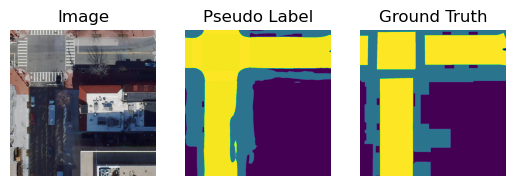

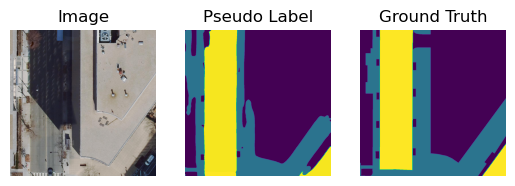

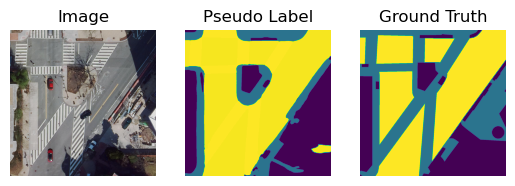

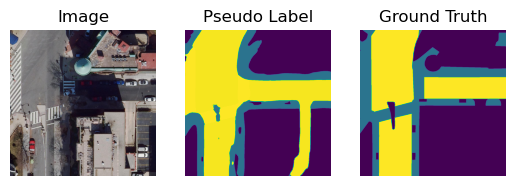

In [7]:
# Visualize the dataset

for idx, (images, masks, gts, _) in enumerate((dataloader)):
    for i in range(images.shape[0]):
        image = (images[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        mask = (masks[i].squeeze().cpu().numpy() * 255).astype(np.uint8)
        gt = (gts[i].squeeze().cpu().numpy() * 255).astype(np.uint8)
        
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title('Pseudo Label')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(gt)
        plt.title('Ground Truth')
        plt.axis('off')
        
        plt.show()

In [8]:
#defining you model
predictor = SamPredictor(sam)
num_classes = 3  # number of classes in the dataset 
#defining one-hot encoding
post_label = AsDiscrete(to_onehot=num_classes)
post_pred = AsDiscrete(threshold=128)

#your evaluation metric, you can change it to anything else
mIOU_metric_batch = MeanIoU(include_background=False, reduction="mean_batch", get_not_nans=True)

#inference loop
classes = [0, 29, 75] # 0=background, 29 = pedestrian, 75 = road, (it depends on the original color of the masks in the gts)
class_names = ["Background","Sidewalk and crosswalk", "Roads"]

In [9]:
if chatGPT==False:
    mod_cls_txt_encoding = torch.load("/home/avisionguy/GeoSAM/mod_cls_txt_encoding.pth").to(device)

input_size = (1024,1024)
original_size = (1024,1024)
mask_threshold = 0.0

In [15]:
#for visualizing
def visualize(predictions):
    temp1 = predictions[0].permute(1, 2, 0)
    temp1[:,:,0] = 0 
    temp = torch.zeros_like(temp1)
    temp[:, :, 1][temp1[:, :, 2] != 0] = 255

    temp[:, :, 2][temp1[:, :, 1] != 0] = 255
    temp = temp.permute(2, 0, 1)
    from torchvision import transforms
    ""
    to_grayscale = transforms.Grayscale(num_output_channels=1)
    temp = to_grayscale(temp)
    temp = temp.permute(1, 2, 0)
    temp = np.array(temp).squeeze()
    

    
    temp[(temp==149)]=75
    temp[(temp==178)]=29
    return temp


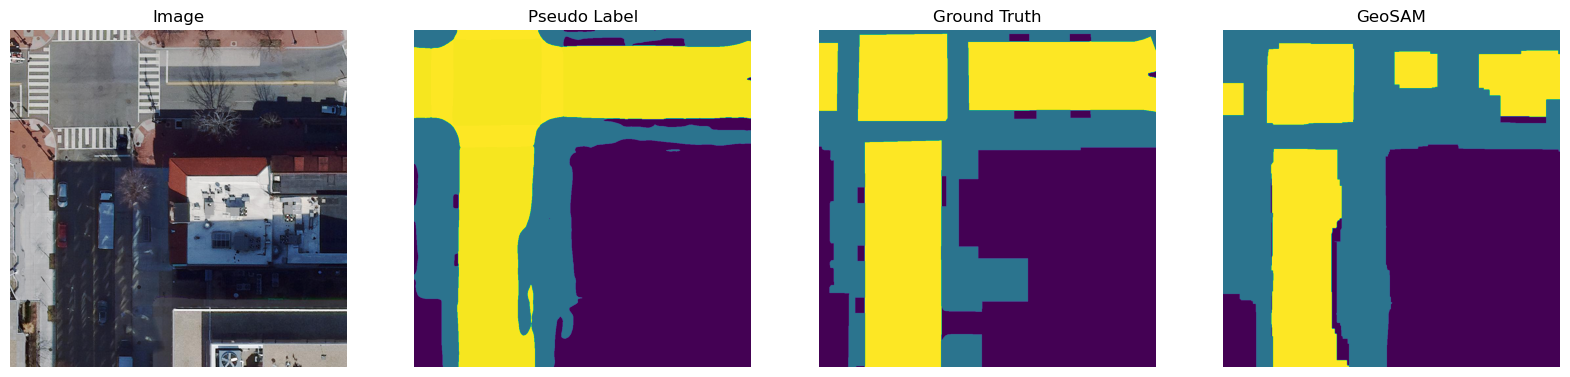

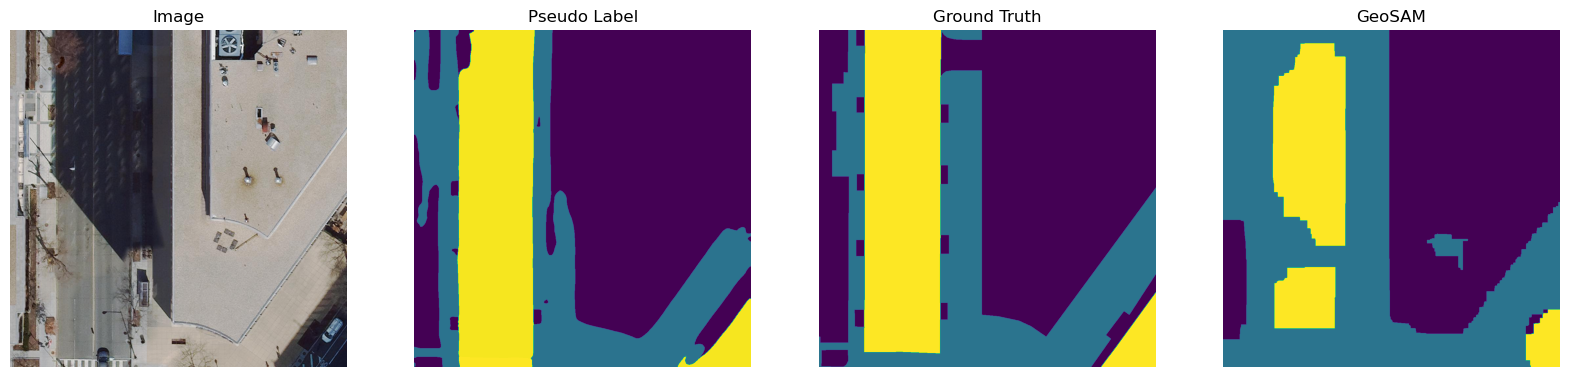

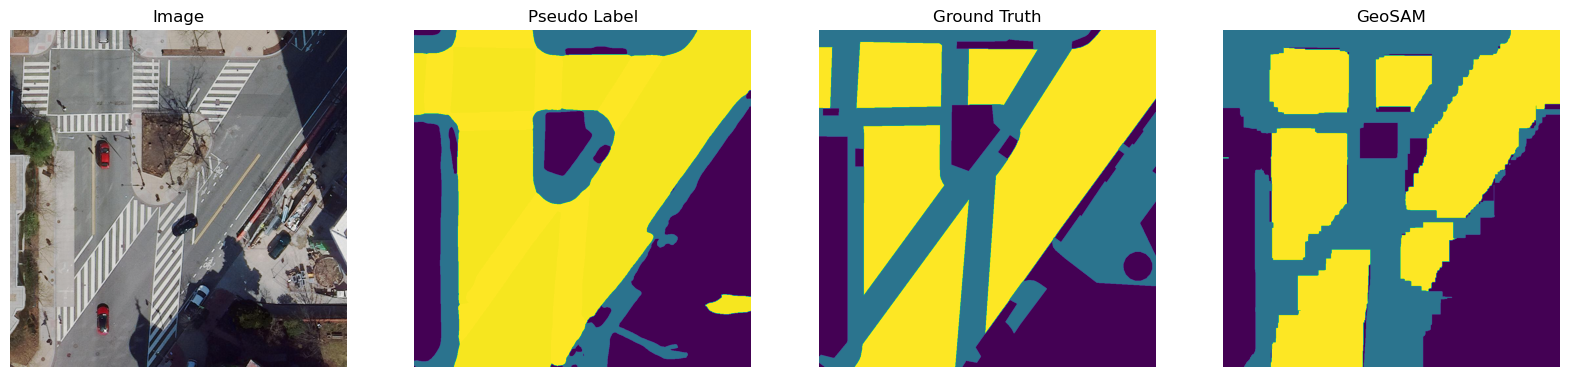

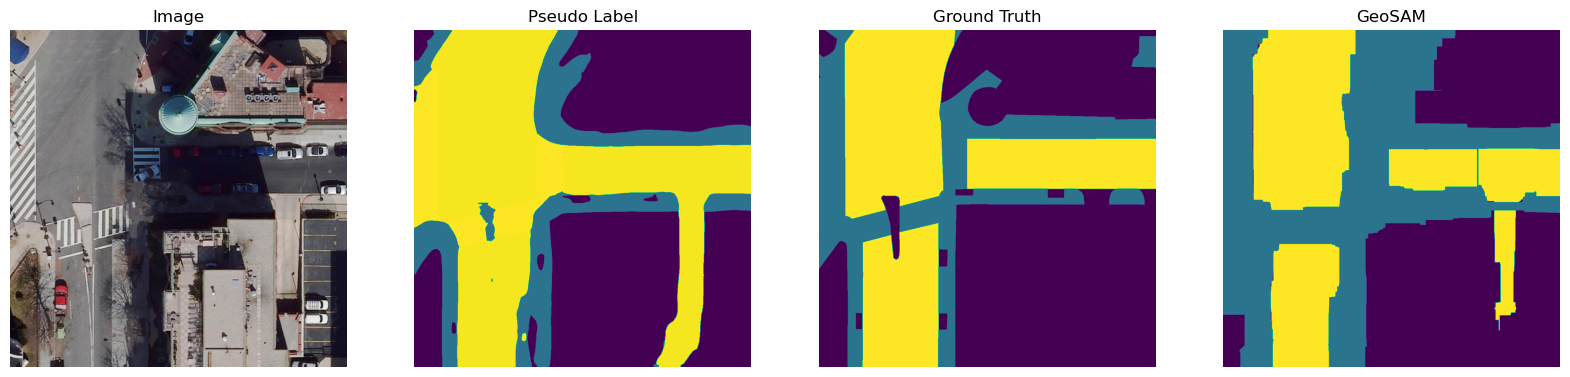

IoU of Sidewalk/Crosswalk: 0.5173872709274292, IoU of road: 0.7846731543540955


In [17]:
mAP=[]
for idx, (images, masks, gts, image_names) in enumerate((dataloader)):
    for i in range(images.shape[0]):
        image = (images[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        mask = (masks[i].squeeze().cpu().numpy() * 255).astype(np.uint8)
        gt = (gts[i].squeeze().cpu().numpy() * 255).astype(np.uint8)
        
        if np.all(gt == 0):         #if the gt doesn't have any of the class we need we just ignore it
            continue
        
        image_name = image_names[i]

        
        predictions = []

        for channel in range(len(classes)):
            if channel == 0:
                    embeddings = None
            else:
                if chatGPT == True:
                    embeddings = utils.chatGPT_description(class_names[channel],device).to(device)
                    embeddings = embeddings.squeeze(0)
                    # print(embeddings.shape)                                 #torch.Size([512])  
                else:
                    embeddings = mod_cls_txt_encoding[0][channel-1]       #torch.Size([512])    
                with autocast():
                    embeddings = projection_layer(embeddings.half())    #torch.Size([256])
            predictor.set_image(image)
            image_embedding = predictor.get_image_embedding()
            # print(image_names[i])
            
            left_clicks, right_clicks = utils.get_random_points(mask,classes[channel])
            #sparse prompts
            all_points = np.concatenate((left_clicks, right_clicks), axis=0)
            all_points = np.array(all_points)
            point_labels = np.array([1]*left_clicks.shape[0] + [0]*right_clicks.shape[0], dtype=int)
            
            
            if len(all_points)==0:      #if the model can't generate any sparse prompts
                transform = ResizeLongestSide(sam.image_encoder.img_size)
                
                if embeddings!=None:
                    embeddings = embeddings.unsqueeze(0).unsqueeze(0)
                    
                if text==True:
                            sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                                points=None,
                                boxes=embeddings,
                                masks=None,
                            )
                else:
                    sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                        points=None,
                        boxes=None,
                        masks=None,
                    )
            
            
                low_res_masks, iou_predictions = sam.mask_decoder(
                    image_embeddings=image_embedding.to(device), 
                    image_pe=sam.prompt_encoder.get_dense_pe(), 
                    sparse_prompt_embeddings=sparse_embeddings, 
                    dense_prompt_embeddings=dense_embeddings, 
                    multimask_output=False,
                )
  
             
                
                output_mask = sam.postprocess_masks(low_res_masks, input_size, original_size)
                output_mask = output_mask > mask_threshold
                output_mask = output_mask[0].detach().cpu().numpy()
                
                #post-processing
                output_mask_processed = utils.post_process_segmentation_map(output_mask)
                predictions.append(torch.from_numpy(output_mask_processed.squeeze()))
                
            else:
                transform = ResizeLongestSide(sam.image_encoder.img_size)
                
                if embeddings!=None:
                    embeddings = embeddings.unsqueeze(0).unsqueeze(0)
                
                all_points = transform.apply_coords(all_points, (image.shape[0], image.shape[0])) 
                all_points = torch.as_tensor(all_points, dtype=torch.float, device=device)
                point_labels = torch.as_tensor(point_labels, dtype=torch.float, device=device)
                all_points, point_labels = all_points[None, :, :], point_labels[None, :]
                points = (all_points, point_labels)  
                    
                if text==True:
                            sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                                points=points,
                                boxes=embeddings,
                                masks=None,
                            )
                else:
                    sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                        points=points,
                        boxes=None,
                        masks=None,
                    )
                
            
                low_res_masks, iou_predictions = sam.mask_decoder(
                    image_embeddings=image_embedding.to(device), 
                    image_pe=sam.prompt_encoder.get_dense_pe(), 
                    sparse_prompt_embeddings=sparse_embeddings, 
                    dense_prompt_embeddings=dense_embeddings, 
                    multimask_output=False,
                )
                
                
                
                output_mask = sam.postprocess_masks(low_res_masks, input_size, original_size)
                output_mask = output_mask > mask_threshold
                
                output_mask = output_mask[0].detach().cpu().numpy()
                
                #post-processing
                output_mask_processed = utils.post_process_segmentation_map(output_mask)
                predictions.append(torch.from_numpy(output_mask_processed.squeeze()))
        
        predictions = torch.stack(predictions).unsqueeze(0)
        
        pred = visualize(predictions)
        
        #visualizing
        plt.figure(figsize=(20, 20))
        plt.subplot(1, 4, 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')
        
        plt.subplot(1, 4, 2)
        plt.imshow(mask)
        plt.title('Pseudo Label')
        plt.axis('off')
        
        plt.subplot(1, 4, 3)
        plt.imshow(gt)
        plt.title('Ground Truth')
        plt.axis('off')
        
        plt.subplot(1,4,4)
        plt.imshow(pred)
        plt.title("GeoSAM")
        plt.axis("off")

        plt.show()
        
        #for calculating mIoU
        predictions = [post_pred(i) for i in decollate_batch(predictions)]
        gts = [post_label(i) for i in decollate_batch(utils.categorize(gts))]
        temp1 = predictions[0].permute(1, 2, 0)
  
        mIOU_metric_batch(y_pred=predictions, y=gts)
        
        

metric_batch = mIOU_metric_batch.aggregate()
print(f"IoU of Sidewalk/Crosswalk: {metric_batch[0][0].item()}, IoU of road: {metric_batch[0][1].item()}")

